In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [9]:
dataset = pd.read_csv('../dataset/heart_2020_cleaned.csv')

dataset.replace( {'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1, 'No, borderline diabetes': 0, 'Yes (during pregnancy)': 1}, inplace=True)
dataset.replace( {'0-17': 0, '18-24': 1, '25-29': 2, '30-34': 3, '35-39': 4, '40-44': 5, '45-49': 6, '50-54': 7, '55-59': 8, '60-64': 9, '65-69': 10, '70-74': 11, '75-79': 12, '80 or older': 13}, inplace=True)
dataset.drop(['Race', 'GenHealth','Stroke','DiffWalking','PhysicalHealth','Asthma','MentalHealth','Diabetic','KidneyDisease','SkinCancer'], axis=1,inplace=True)

feature_names = ['BMI','Smoking','AlcoholDrinking','Sex', 'AgeCategory','PhysicalActivity','SleepTime']
target_names = 'HeartDisease'

true_dataset  = []
false_dataset = []

df_positive = dataset[ dataset['HeartDisease'] == 1 ] 
df_negative = dataset[ dataset['HeartDisease'] == 0 ]
df_negative_cut = df_negative.sample(n = 30000)
dataset = pd.concat([df_positive, df_negative_cut])

target = dataset[target_names]
feature = dataset[feature_names]

print (target.value_counts())
dataset

0    30000
1    27373
Name: HeartDisease, dtype: int64


,HeartDisease,BMI,Smoking,AlcoholDrinking,Sex,AgeCategory,PhysicalActivity,SleepTime
5,1,28.87,1,0,0,12,0,12.0
10,1,34.30,1,0,1,9,0,15.0
35,1,32.98,1,0,1,12,1,4.0
42,1,25.06,0,0,0,13,0,7.0
43,1,30.23,1,0,0,12,1,8.0
...,...,...,...,...,...,...,...,...
215939,0,32.28,1,0,1,11,0,7.0
54942,0,44.64,0,0,0,12,0,8.0
67789,0,25.00,0,0,1,3,1,8.0
231347,0,21.25,0,0,1,1,1,4.0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    feature,target,
    test_size=0.2,
    random_state=np.random.randint(10))

In [11]:
batch_size = 20
X_train=np.asarray(X_train).astype(float)
y_train=np.asarray(y_train).astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)

X_test=np.asarray(X_test).astype(float)
y_test=np.asarray(y_test).astype(int)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size)

In [12]:
inputs = keras.Input(shape=(7,))
h1 = keras.layers.Dense(10,activation=tf.nn.relu)(inputs)
h2 = keras.layers.Dense(10,activation=tf.nn.relu)(h1)
outputs = keras.layers.Dense(2)(h2)
model = keras.Model(inputs=inputs, outputs=outputs, name="heart_disease_model")

model.summary()

Model: "heart_disease_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_9 (Dense)             (None, 10)                80        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 2)                 22        
                                                                 
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________


In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [14]:
next_batch_dataset = next(iter(train_dataset))
features,labels = next_batch_dataset
predictions = model(features)

print(f"Prediction: {tf.argmax(predictions, axis=1)}")
print(f"    Labels: {labels}")

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0]


In [15]:
def loss(model, x, y, training):
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print(f"Loss test: {l}")

Loss test: 3.56329083442688


In [16]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [17]:
loss_value, grads = grad(model, features, labels)

print(f"Step: {optimizer.iterations.numpy()}, Initial Loss: {loss_value.numpy()}")

optimizer.apply_gradients(zip(grads, model.trainable_variables))
print(f"Step: {optimizer.iterations.numpy()}, Loss: {loss(model, features, labels, training=True).numpy()}")



Step: 0, Initial Loss: 3.56329083442688
Step: 1, Loss: 5.094476699829102


In [19]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 101

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  
        epoch_accuracy.update_state(y, model(x, training=True))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    if epoch % 10 == 0: print(f"Epoch {epoch:03d}: Loss: {epoch_loss_avg.result():.3f}, Accuracy: {epoch_accuracy.result():.3%}")

Epoch 000: Loss: 0.609, Accuracy: 71.312%
Epoch 010: Loss: 0.559, Accuracy: 73.256%
Epoch 020: Loss: 0.555, Accuracy: 73.099%
Epoch 030: Loss: 0.554, Accuracy: 73.082%
Epoch 040: Loss: 0.553, Accuracy: 73.186%
Epoch 050: Loss: 0.553, Accuracy: 73.195%
Epoch 060: Loss: 0.553, Accuracy: 73.162%
Epoch 070: Loss: 0.552, Accuracy: 73.125%
Epoch 080: Loss: 0.552, Accuracy: 73.064%
Epoch 090: Loss: 0.552, Accuracy: 73.088%
Epoch 100: Loss: 0.551, Accuracy: 73.106%


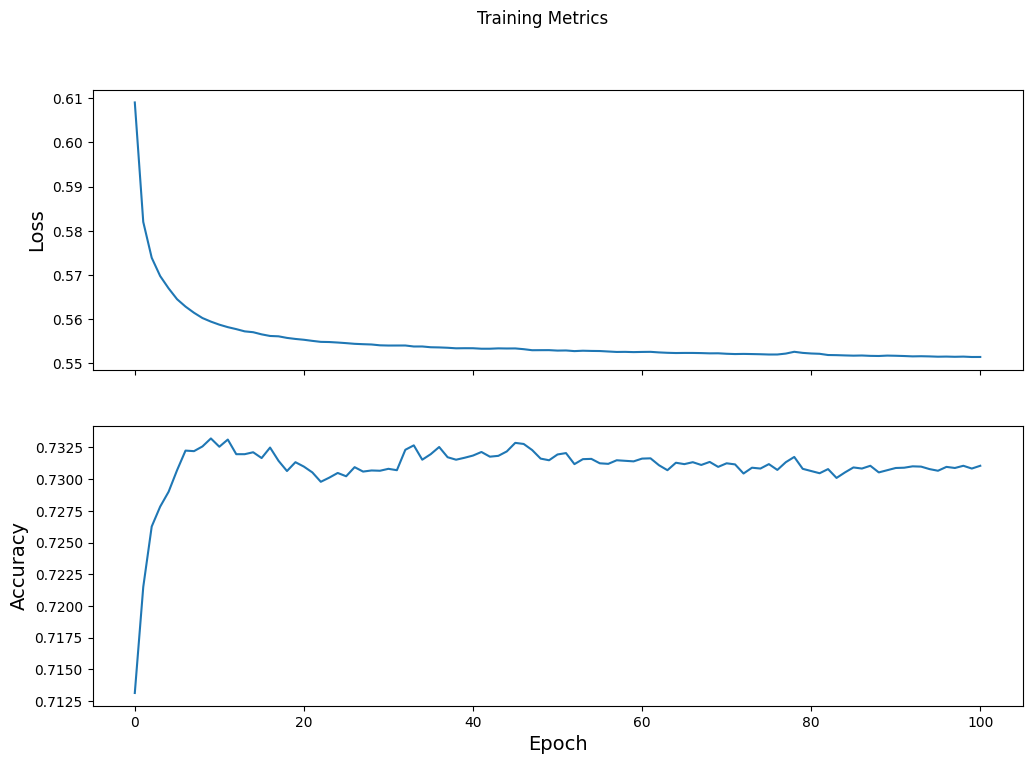

In [20]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [21]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  softmax_result = tf.nn.softmax(logits, axis=1)
  test_accuracy(prediction, y)

print(f"Test set accuracy: {test_accuracy.result():.3%}")

Test set accuracy: 71.373%


In [22]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets
